## Lista De Exercícios

Grupo:
- Gregory Filipe Lira da Silva
- Danilo Henrique da Silva Santana
- Dayvison Gomes de Oliveira

### Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import MinMaxScaler


from Perceptron_ import *
from nn import *

sns.set_style('whitegrid')

## Questão 01

1) A representação de uma determinada mensagem digital ternária, isto é formada por três bits,
forma um cubo cujos vértices correspondem a mesma representação digital. Supondo que ao
transmitirmos esta mensagem a mesma possa ser contaminada por ruído formado em torno de
cada vértice uma nuvem esférica de valores aleatórios com raio máximo é 0.1. Formule este
problema como um problema de classificação de padrões e treine uma Rede Perceptron de
Rosenblatt (Perceptron de camada única) para atuar como classificador/decodificador. Para
solução do problema defina antes um conjunto de treinamento e um conjunto de validação

In [ ]:
dados = np.array([[0,0,0],
                 [0,0,1],
                 [0,1,0],
                 [0,1,1],
                 [1,0,0],
                 [1,0,1],
                 [1,1,0],
                 [1,1,1]])

dados.shape

(8, 3)

In [ ]:
classes = np.array( [i for i in range(8)] ).T

In [ ]:
dados = np.column_stack((dados,classes))

dados

array([[0, 0, 0, 0],
       [0, 0, 1, 1],
       [0, 1, 0, 2],
       [0, 1, 1, 3],
       [1, 0, 0, 4],
       [1, 0, 1, 5],
       [1, 1, 0, 6],
       [1, 1, 1, 7]])

In [ ]:
df = pd.DataFrame(dados, columns=['One','Two','Three','Class'])

df

,One,Two,Three,Class
0,0,0,0,0
1,0,0,1,1
2,0,1,0,2
3,0,1,1,3
4,1,0,0,4
5,1,0,1,5
6,1,1,0,6
7,1,1,1,7


In [ ]:
def create_new_df(df, number_new_dados):
    new_df = df.copy()
    values = new_df[['One','Two','Three']].values

    for passo in range(number_new_dados):

        ruido = np.array([np.random.uniform(-0.1,0.1) for i in range(24)]).reshape(8,3)

        new_values = values + ruido

        for i in range(len(new_values)):
            new_df.loc[len(new_df)] = [new_values[i][0],new_values[i][1],new_values[i][2],i]

    return new_df

In [ ]:
new_df = create_new_df(df, 500)
new_df = new_df.sort_values(by=['Class'])
new_df

,One,Two,Three,Class
0,0.000000,0.000000,0.000000,0.0
2960,-0.010038,-0.094023,0.071368,0.0
840,-0.055161,-0.007782,-0.006545,0.0
2952,0.017210,0.020477,-0.006850,0.0
848,0.000320,-0.054151,0.017764,0.0
...,...,...,...,...
2599,1.084182,0.952437,0.985466,7.0
1127,1.074972,1.009025,0.997549,7.0
2591,0.944529,1.008601,1.075278,7.0
2615,0.912905,1.010393,0.944183,7.0


In [ ]:
new_df['Class'].value_counts()

7.0    501
6.0    501
5.0    501
4.0    501
3.0    501
2.0    501
1.0    501
0.0    501
Name: Class, dtype: int64

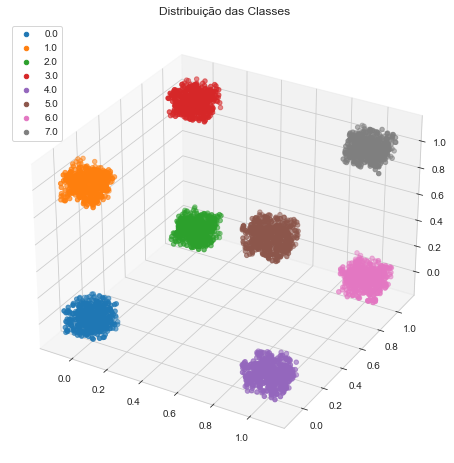

In [ ]:
def plot3d(df):

    classes = df['Class'].unique()

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')

    for classe in classes:
        valores = df[df['Class'] == classe].values
        x,y,z = valores[:,0] , valores[:,1], valores[:,2]
        ax.scatter(x,y,z, label=classe)

    ax.set_title("Distribuição das Classes")
    ax.legend(loc="best")

plot3d(new_df)

In [ ]:
X = new_df[['One','Two','Three']].values
y = new_df[['Class']].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
X_train.shape , X_test.shape

((2805, 3), (1203, 3))

### Perceptron Sklearn

In [ ]:
model = Perceptron()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [ ]:
print('Reporte: \n')
print(classification_report(y_test,y_pred))
print('Matriz de confusão: \n')
print(confusion_matrix(y_test,y_pred))

Reporte: 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       142
         1.0       1.00      1.00      1.00       158
         2.0       1.00      1.00      1.00       150
         3.0       1.00      1.00      1.00       143
         4.0       1.00      1.00      1.00       148
         5.0       1.00      1.00      1.00       149
         6.0       1.00      1.00      1.00       159
         7.0       1.00      1.00      1.00       154

    accuracy                           1.00      1203
   macro avg       1.00      1.00      1.00      1203
weighted avg       1.00      1.00      1.00      1203

Matriz de confusão: 

[[142   0   0   0   0   0   0   0]
 [  0 158   0   0   0   0   0   0]
 [  0   0 150   0   0   0   0   0]
 [  0   0   0 143   0   0   0   0]
 [  0   0   0   0 148   0   0   0]
 [  0   0   0   0   0 149   0   0]
 [  0   0   0   0   0   0 159   0]
 [  0   0   0   0   0   0   0 154]]


### Implementação - Perceptron

In [ ]:
dim_entrada = X.shape[1]
dim_saida = 8

model = Perceptron_(dim_entrada,dim_saida,ini_pesos=random_normal, learning_rate=1e-3)
model.fit(X_train,y_train, epochs=200, verbose=100)
y_pred = model.predict(X_test)

epoch:    0/200 loss_train: 3.62869875
epoch:  100/200 loss_train: 0.61550802
epoch:  200/200 loss_train: 0.66274510


In [ ]:
print('Reporte: \n')
print(classification_report(y_test,y_pred))
print('Matriz de confusão: \n')
print(confusion_matrix(y_test,y_pred))

Reporte: 

              precision    recall  f1-score   support

         0.0       1.00      0.20      0.34       142
         1.0       0.96      1.00      0.98       158
         2.0       0.80      0.99      0.88       150
         3.0       0.91      1.00      0.95       143
         4.0       0.86      1.00      0.92       148
         5.0       0.90      1.00      0.95       149
         6.0       0.96      1.00      0.98       159
         7.0       0.96      0.99      0.97       154

    accuracy                           0.90      1203
   macro avg       0.92      0.90      0.87      1203
weighted avg       0.92      0.90      0.88      1203

Matriz de confusão: 

[[ 29   7  38  15  25  15   6   7]
 [  0 158   0   0   0   0   0   0]
 [  0   0 149   0   0   0   1   0]
 [  0   0   0 143   0   0   0   0]
 [  0   0   0   0 148   0   0   0]
 [  0   0   0   0   0 149   0   0]
 [  0   0   0   0   0   0 159   0]
 [  0   0   0   0   0   2   0 152]]


## Questão 2

2) Implemente uma rede perceptron de múltiplas camadas e utilize-a para aproximar as
funções abaixo. Em seguida, compare os resultados com as curvas exatas. No caso das letras
(b) e (c), apresente também a curva do erro médio de treinamento com relação ao número de
épocas e a curva do erro médio com o conjunto de validação.

    a) a função lógica XOR

    b) f(x) = log10(x), onde 1 ≤ x ≤ 10

    c) f(x) = 10x^5+ 5x^4+ 2x^3– 0.5x^2+ 3x + 2, onde 0 ≤ x ≤ 5


### $a)$A função lógica XOR

In [ ]:
dados = np.array([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]])

saida = np.array([[0,1,1,0]]).T

dados_ = np.column_stack((dados,saida))

In [ ]:
df = pd.DataFrame(dados_, columns=['One','Two','Class'])
df

,One,Two,Class
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


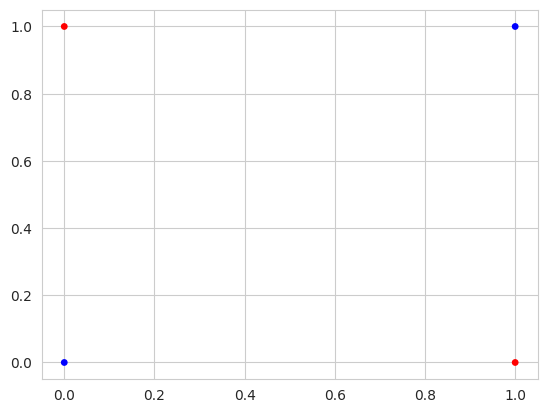

In [ ]:
plt.scatter(dados[:,0],dados[:,1], c=saida, s=15, cmap='bwr')

In [ ]:
def create_new_df_2(df, number_new_dados):
    new_df = df.copy()
    values = new_df[['One','Two']].values

    for passo in range(number_new_dados):

        ruido = np.array([np.random.uniform(-0.3,0.3) for i in range(8)]).reshape(4,2)

        new_values = values + ruido

        for i in range(len(new_values)):
            if i == 2:
                new_df.loc[len(new_df)] = [new_values[i][0],new_values[i][1],1]
            elif i == 3:
                new_df.loc[len(new_df)] = [new_values[i][0],new_values[i][1],0]
            else:
                new_df.loc[len(new_df)] = [new_values[i][0],new_values[i][1],i]

    return new_df

In [ ]:
new_df = create_new_df_2(df, 200)

In [ ]:
new_df

,One,Two,Class
0,0.000000,0.000000,0.0
1,0.000000,1.000000,1.0
2,1.000000,0.000000,1.0
3,1.000000,1.000000,0.0
4,-0.055891,-0.175484,0.0
...,...,...,...
799,1.135552,0.873758,0.0
800,-0.160499,-0.280004,0.0
801,0.035864,0.818309,1.0
802,0.834851,-0.268221,1.0


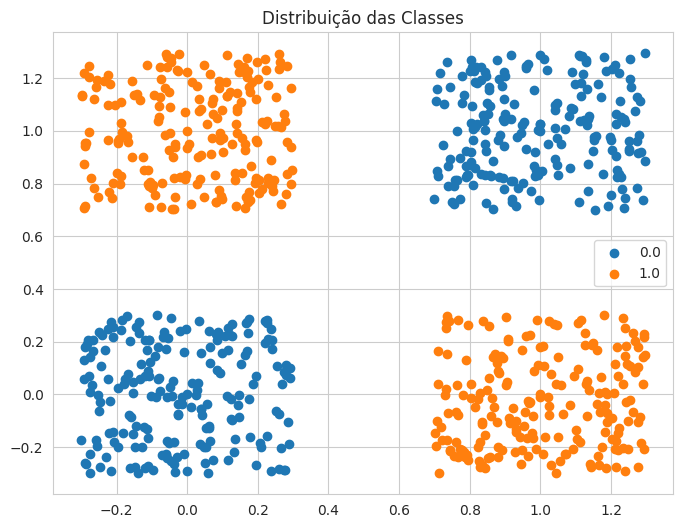

In [ ]:
def plot2d(df):

    classes = df['Class'].unique()

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)

    for classe in classes:
        valores = df[df['Class'] == classe].values
        x,y = valores[:,0] , valores[:,1]
        ax.scatter(x,y, label=classe)

    ax.set_title("Distribuição das Classes")
    ax.legend(loc="best")

plot2d(new_df)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_df[['One','Two']].values, new_df['Class'], test_size=0.3)
X_test.shape

(242, 2)

### MLPClassifier Sklearn

In [ ]:
model = MLPClassifier(max_iter=1000)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       129
         1.0       1.00      1.00      1.00       113

    accuracy                           1.00       242
   macro avg       1.00      1.00      1.00       242
weighted avg       1.00      1.00      1.00       242



<Axes: >

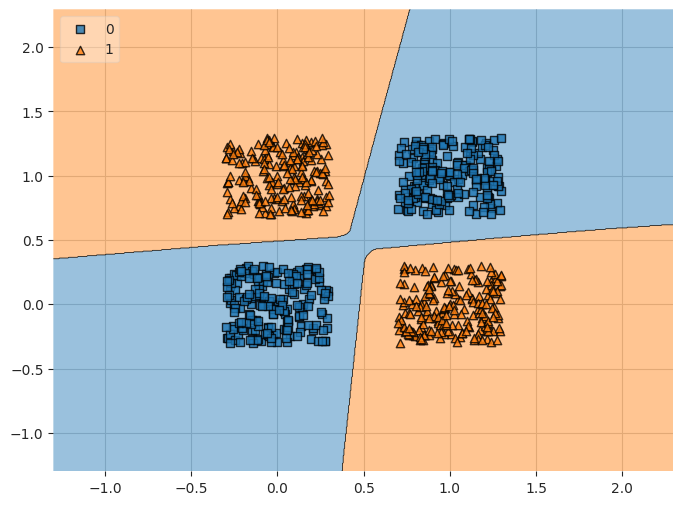

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plot_decision_regions(X=new_df[['One','Two']].values, y=new_df['Class'].ravel().astype(np.int_), clf=model, legend=2)

### Implementação da rede

In [ ]:
y_train = y_train.reshape(-1,1)
dim_entrada = X_train.shape[1]
dim_saida = y_train.shape[1]

model = NeuralNetwork(func_cost=cross_entropy, learning_rate=1e-1)

model.layers.append(Layer(dim_entrada=dim_entrada, dim_saida=10, activation=relu))
model.layers.append(Layer(dim_entrada=10, dim_saida=10, activation=relu))
model.layers.append(Layer(dim_entrada=10, dim_saida=dim_saida, activation=sigmoid))

history = model.fit(X_train,y_train, X_test, y_test.to_numpy().reshape(-1,1), epochs=3000, verbose=300)

y_pred = model.predict(X_test)

epoch:    0/3000 loss_train: 0.94641798
epoch:  300/3000 loss_train: 0.00941967
epoch:  600/3000 loss_train: 0.00452412
epoch:  900/3000 loss_train: 0.00286292
epoch: 1200/3000 loss_train: 0.00204136
epoch: 1500/3000 loss_train: 0.00156254
epoch: 1800/3000 loss_train: 0.00125577
epoch: 2100/3000 loss_train: 0.00104435
epoch: 2400/3000 loss_train: 0.00088893
epoch: 2700/3000 loss_train: 0.00077068
epoch: 3000/3000 loss_train: 0.00067938


In [ ]:
for i in range(len(y_pred)):
    if y_pred[i,0] >= 0.5:
        y_pred[i,0] = 1
    else:
        y_pred[i,0] = 0

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       129
         1.0       1.00      1.00      1.00       113

    accuracy                           1.00       242
   macro avg       1.00      1.00      1.00       242
weighted avg       1.00      1.00      1.00       242



<Axes: >

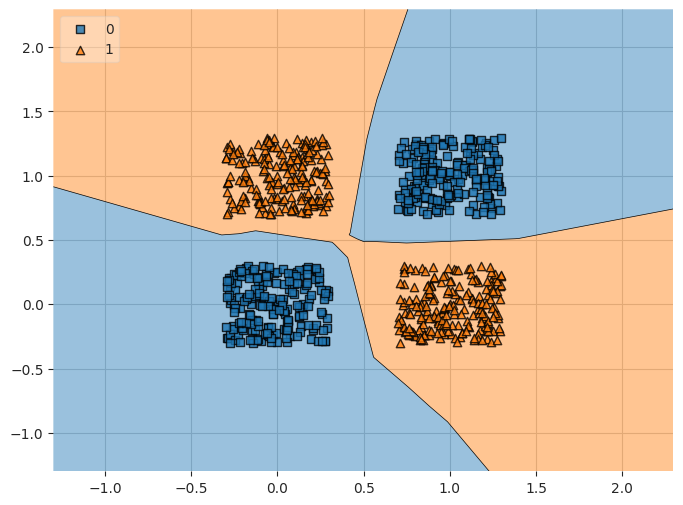

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plot_decision_regions(X=new_df[['One','Two']].values, y=new_df['Class'].ravel().astype(np.int_), clf=model, legend=2)

### $b) f(x) = \log_{10}(x) , 1 \leq x \leq 10$

In [ ]:
x = np.linspace(1,10,200)
f = lambda x: np.log(x)
y = f(x)
y = np.array([y])

In [ ]:
df = pd.DataFrame(data={'x':x,'y':y[0]})
df

,x,y
0,1.000000,0.000000
1,1.045226,0.044233
2,1.090452,0.086593
3,1.135678,0.127230
4,1.180905,0.166281
...,...,...
195,9.819095,2.284329
196,9.864322,2.288924
197,9.909548,2.293499
198,9.954774,2.298052


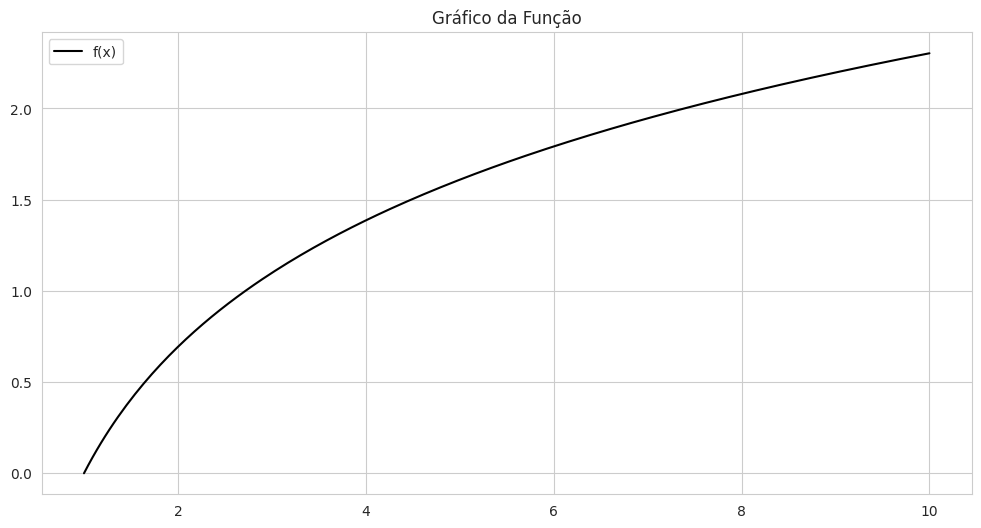

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

ax.set_title('Gráfico da Função')
ax.plot(x,y[0], c='black',label='f(x)')
ax.legend(loc='best')

### Normalização dos dados

In [ ]:
minmax = MinMaxScaler()

X_train, X_test, y_train,y_test = train_test_split(x,y[0], test_size=0.3)
X_train = minmax.fit_transform(X_train.reshape(-1,1))
X_test = minmax.transform(X_test.reshape(-1,1))

X_train.shape

(140, 1)

### Rede Keras

In [ ]:
model_ = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1)),
    tf.keras.layers.Dense(10, activation='tanh'),
    tf.keras.layers.Dense(10, activation='tanh'),
    tf.keras.layers.Dense(1, activation='linear')
])

model_.compile(optimizer='adam',metrics=['mean_squared_error'],loss =['mean_squared_error'] )
history = model_.fit(X_train, y_train,epochs=100,validation_data=(X_test,y_test))

Epoch 1/100
5/5 [==============================] - 1s 56ms/step - loss: 3.0384 - mean_squared_error: 3.0384 - val_loss: 2.8568 - val_mean_squared_error: 2.8568
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 2.7284 - mean_squared_error: 2.7284 - val_loss: 2.5652 - val_mean_squared_error: 2.5652
Epoch 3/100
5/5 [==============================] - 0s 14ms/step - loss: 2.4474 - mean_squared_error: 2.4474 - val_loss: 2.2944 - val_mean_squared_error: 2.2944
Epoch 4/100
5/5 [==============================] - 0s 14ms/step - loss: 2.1845 - mean_squared_error: 2.1845 - val_loss: 2.0438 - val_mean_squared_error: 2.0438
Epoch 5/100
5/5 [==============================] - 0s 15ms/step - loss: 1.9476 - mean_squared_error: 1.9476 - val_loss: 1.8116 - val_mean_squared_error: 1.8116
Epoch 6/100
5/5 [==============================] - 0s 12ms/step - loss: 1.7186 - mean_squared_error: 1.7186 - val_loss: 1.5997 - val_mean_squared_error: 1.5997
Epoch 7/100
5/5 [=======================

2/2 [==============================] - 0s 5ms/step
MSE: 0.3388057242067523 
MAE: 0.6610951117889968


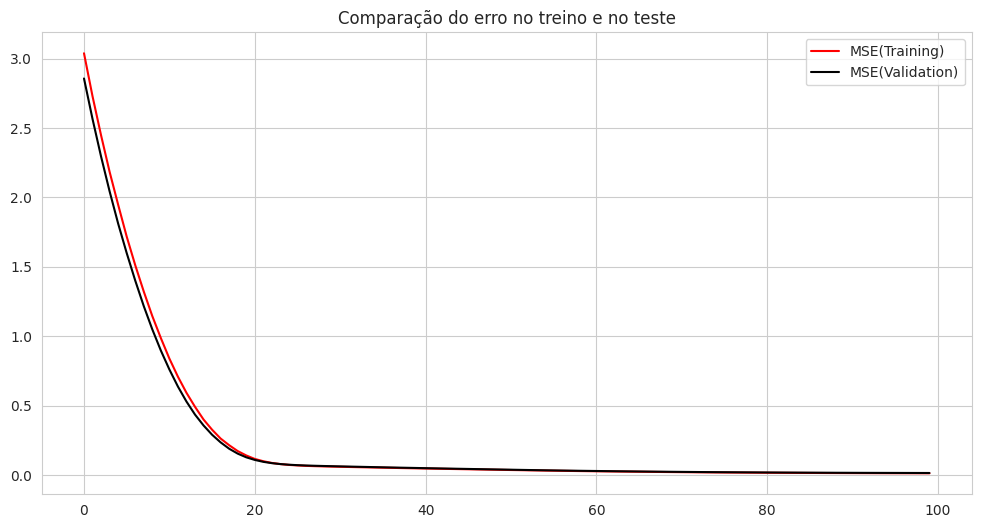

In [ ]:
y_pred_ = model_.predict(X_test)

print(f"MSE: {0.5*np.mean((y_test-y_pred_)**2)} ")
print(f"MAE: {np.mean(abs(y_test-y_pred_))}")

plt.figure(figsize=(12,6))
plt.title('Comparação do erro no treino e no teste')
plt.plot(history.history['loss'],color='red',label='MSE(Training)')
plt.plot(history.history['val_loss'],color='black',label='MSE(Validation)')
plt.legend(loc='best')

### MLPRegressor Sklearn

MSE: 0.011630111455176206 
MAE: 0.0894203015691624


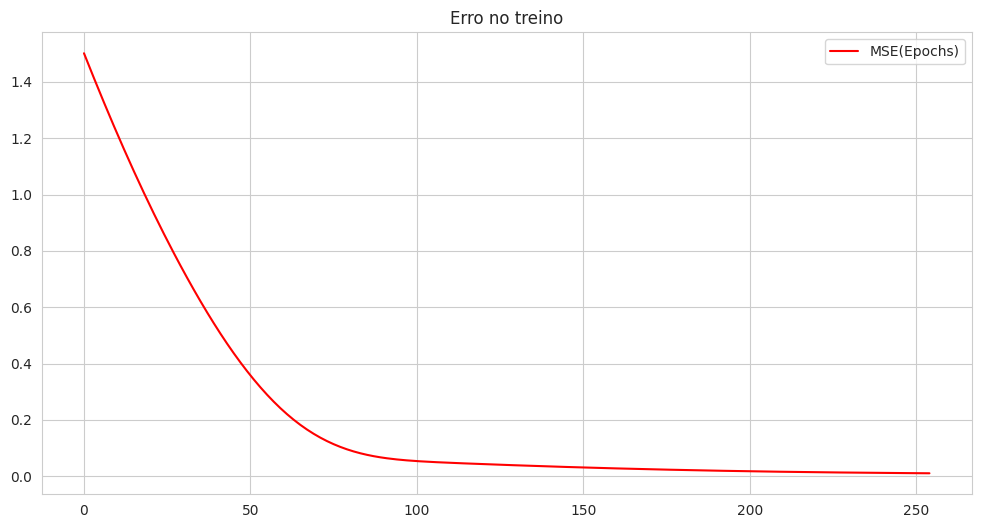

In [ ]:
model__ = MLPRegressor(hidden_layer_sizes=(100,),max_iter=1000)
history = model__.fit(X_train,y_train)
y_pred__ = model__.predict(X_test)

print(f"MSE: {0.5*np.mean((y_test-y_pred__)**2)} ")
print(f"MAE: {np.mean(abs(y_test-y_pred__))}")

plt.figure(figsize=(12,6))
plt.title('Erro no treino')
plt.plot(history.loss_curve_,color='red',label='MSE(Epochs)')
plt.legend(loc='best')

### Implementação da rede

In [ ]:
y_train = y_train.reshape(-1,1)
dim_entrada = X_train.shape[1]
dim_saida = y_train.shape[1]

model = NeuralNetwork(func_cost=mse, learning_rate=1e-1)

model.layers.append(Layer(dim_entrada=dim_entrada, dim_saida=10, activation=tanh ))
model.layers.append(Layer(dim_entrada=10, dim_saida=10, activation=tanh ))
model.layers.append(Layer(dim_entrada=10, dim_saida=dim_saida, activation=linear))

history = model.fit(X_train,y_train, X_test, y_test.reshape(-1,1), epochs=3000, verbose=300)
y_pred = model.predict(X_test)

epoch:    0/3000 loss_train: 0.23468182
epoch:  300/3000 loss_train: 0.00201923
epoch:  600/3000 loss_train: 0.00081899
epoch:  900/3000 loss_train: 0.00041699
epoch: 1200/3000 loss_train: 0.00024425
epoch: 1500/3000 loss_train: 0.00016008
epoch: 1800/3000 loss_train: 0.00011547
epoch: 2100/3000 loss_train: 0.00009006
epoch: 2400/3000 loss_train: 0.00007454
epoch: 2700/3000 loss_train: 0.00006438
epoch: 3000/3000 loss_train: 0.00005728


MAE: 0.6691251895855
MSE: 0.3618842368113086 


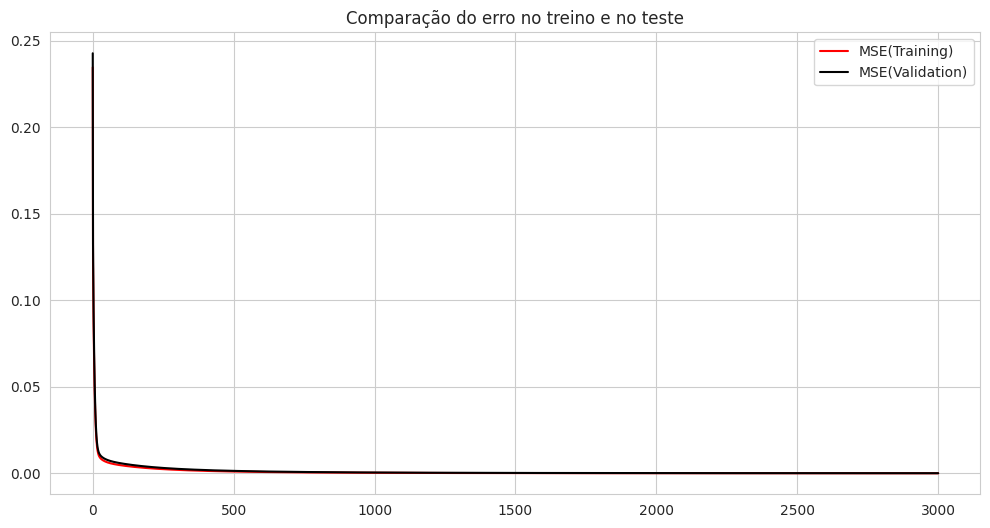

In [ ]:
out = model.predict(x.reshape(-1,1))
print(f"MAE: {np.mean(abs(y_test-y_pred))}")
print(f"MSE: {0.5*np.mean((y_test-y_pred)**2)} ")

plt.figure(figsize=(12,6))
plt.title('Comparação do erro no treino e no teste')
plt.plot(history['loss'],color='red',label='MSE(Training)')
plt.plot(history['val_loss'],color='black',label='MSE(Validation)')
plt.legend(loc='best')

7/7 [==============================] - 0s 3ms/step


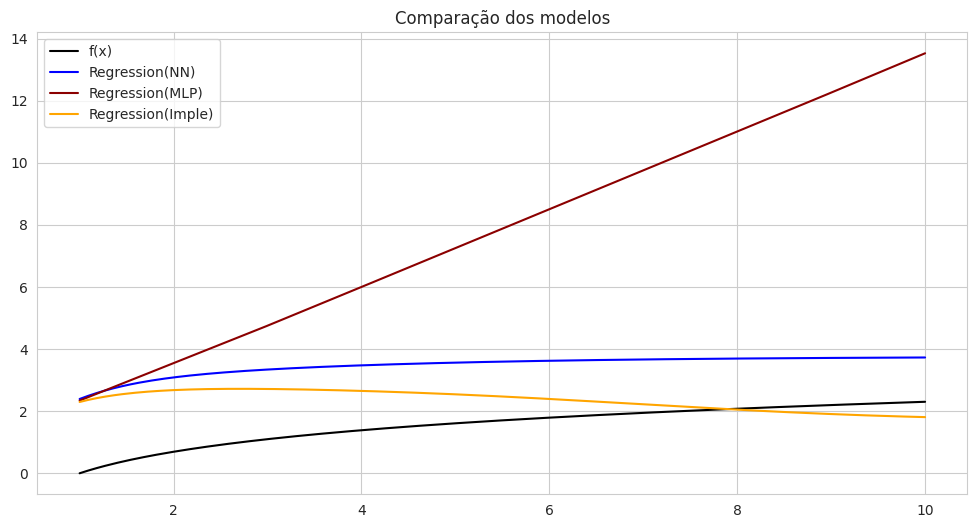

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Comparação dos modelos')
plt.plot(x,y[0],color='black',label='f(x)')
plt.plot(x, model_.predict(x.reshape(-1,1)),color='blue',label='Regression(NN)')
plt.plot(x, model__.predict(x.reshape(-1,1)),color='darkred',label='Regression(MLP)')
plt.plot(x.reshape(-1,1), out ,color = 'orange', label='Regression(Imple)')
plt.legend()

In [ ]:
print('Rede Keras: \n')
print(f"MSE: {0.5*np.mean((y_test-y_pred_)**2)} ")
print(f"MAE: {np.mean(abs(y_test-y_pred_))}")
print('\nMLPRegressor Sklearn: \n')
print(f"MSE: {0.5*np.mean((y_test-y_pred__)**2)} ")
print(f"MAE: {np.mean(abs(y_test-y_pred__))}")
print('\nImplementação da rede: \n')
print(f"MSE: {0.5*np.mean((y_test-y_pred)**2)} ")
print(f"MAE: {np.mean(abs(y_test-y_pred))}")

Rede Keras: 

MSE: 0.3388057242067523 
MAE: 0.6610951117889968

MLPRegressor Sklearn: 

MSE: 0.011630111455176206 
MAE: 0.0894203015691624

Implementação da rede: 

MSE: 0.3618842368113086 
MAE: 0.6691251895855


### $c) f(x) = 10x^{5}+ 5x^{4}+ 2x^{3}– 0.5x^{2} + 3x + 2, 0 \leq x \leq 5$

In [ ]:
x = np.linspace(0,5,200)
f = lambda x: 10*x**5 + 5*x**4 + 2*x**3 - 0.5*x**2 + 3*x + 2
y = f(x)
y = np.array([y])

In [ ]:
df = pd.DataFrame(data={'x':x,'y':y[0]})
df

,x,y
0,0.000000,2.000000
1,0.025126,2.075095
2,0.050251,2.149780
3,0.075377,2.224332
4,0.100503,2.299100
...,...,...
195,4.899497,31354.183296
196,4.924623,32148.718028
197,4.949749,32959.287604
198,4.974874,33786.133598


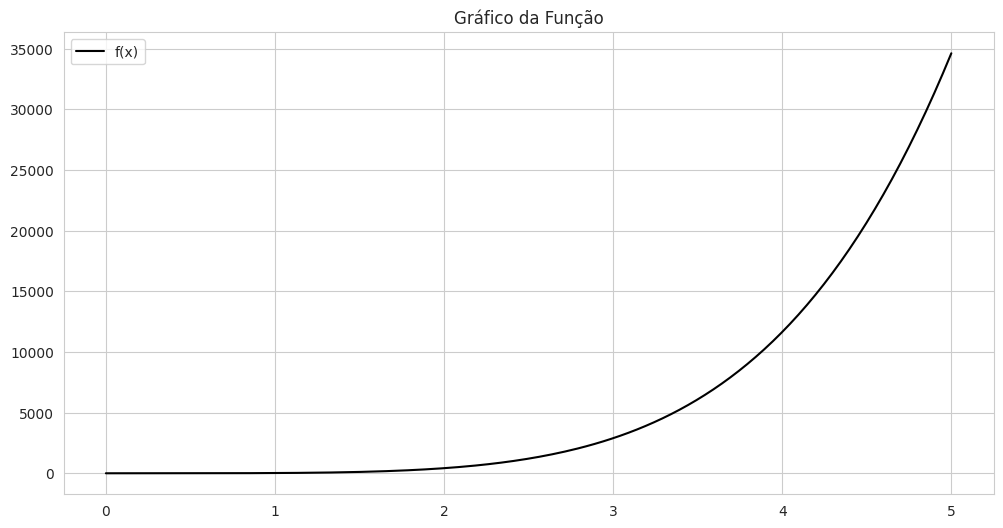

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

ax.set_title('Gráfico da Função')
ax.plot(x,y[0], c='black',label='f(x)')
ax.legend(loc='best')

In [ ]:
minmax = MinMaxScaler()


X_train, X_test, y_train,y_test = train_test_split(x,y[0], test_size=0.3)
X_train = minmax.fit_transform(X_train.reshape(-1,1))
X_test = minmax.transform(X_test.reshape(-1,1))
X_train.shape


(140, 1)

In [ ]:
model_ = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1)),
    tf.keras.layers.Dense(10, activation='tanh'),
    tf.keras.layers.Dense(10, activation='tanh'),
    tf.keras.layers.Dense(1, activation='linear')
])

model_.compile(optimizer='adam',metrics=['mean_squared_error'],loss =['mean_squared_error'] )
history = model_.fit(X_train, y_train,epochs=100,validation_data=(X_test,y_test))

Epoch 1/100
5/5 [==============================] - 1s 53ms/step - loss: 127706840.0000 - mean_squared_error: 127706840.0000 - val_loss: 81576280.0000 - val_mean_squared_error: 81576280.0000
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 127705616.0000 - mean_squared_error: 127705616.0000 - val_loss: 81575376.0000 - val_mean_squared_error: 81575376.0000
Epoch 3/100
5/5 [==============================] - 0s 10ms/step - loss: 127704504.0000 - mean_squared_error: 127704504.0000 - val_loss: 81574488.0000 - val_mean_squared_error: 81574488.0000
Epoch 4/100
5/5 [==============================] - 0s 12ms/step - loss: 127703288.0000 - mean_squared_error: 127703288.0000 - val_loss: 81573648.0000 - val_mean_squared_error: 81573648.0000
Epoch 5/100
5/5 [==============================] - 0s 10ms/step - loss: 127702208.0000 - mean_squared_error: 127702208.0000 - val_loss: 81572792.0000 - val_mean_squared_error: 81572792.0000
Epoch 6/100
5/5 [==============================] -

2/2 [==============================] - 0s 12ms/step
MSE: 59907809.75588841 
MAE: 5957.605033242905


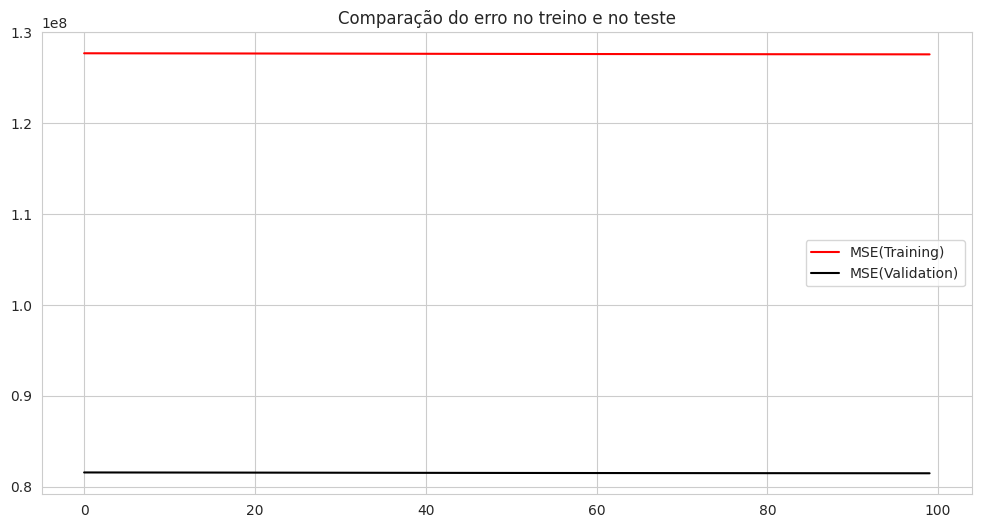

In [ ]:
y_pred_ = model_.predict(X_test)
print(f"MSE: {0.5*np.mean((y_test-y_pred_)**2)} ")
print(f"MAE: {np.mean(abs(y_test-y_pred_))}")

plt.figure(figsize=(12,6))
plt.title('Comparação do erro no treino e no teste')
plt.plot(history.history['loss'],color='red',label='MSE(Training)')
plt.plot(history.history['val_loss'],color='black',label='MSE(Validation)')
plt.legend(loc='best')

###  MLPRegressor Sklearn

MSE: 58701108.794813104 
MAE: 5870.342529252827


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


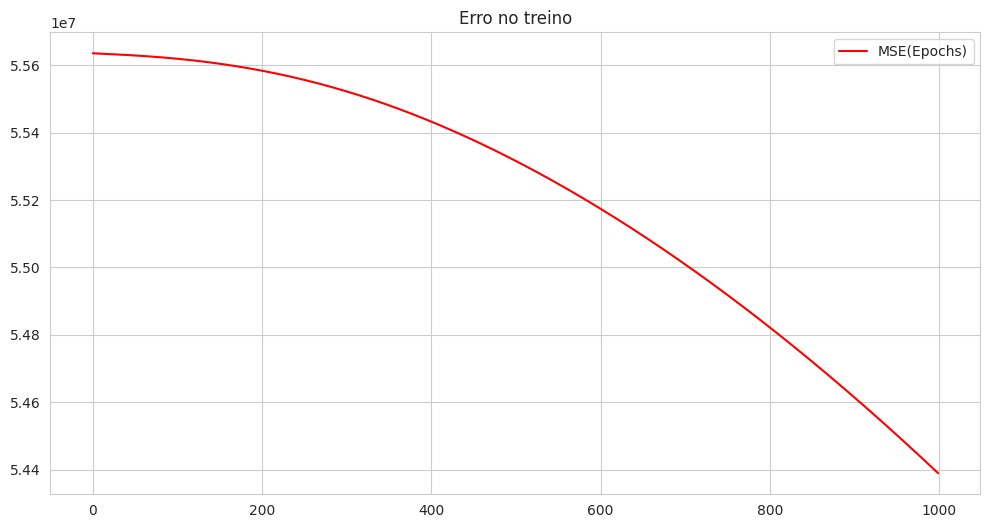

In [ ]:
model__ = MLPRegressor(hidden_layer_sizes=(100,),max_iter=1000)
history = model__.fit(X_train,y_train)
y_pred__ = model__.predict(X_test)

print(f"MSE: {0.5*np.mean((y_test-y_pred__)**2)} ")
print(f"MAE: {np.mean(abs(y_test-y_pred__))}")

plt.figure(figsize=(12,6))
plt.title('Erro no treino')
plt.plot(history.loss_curve_,color='red',label='MSE(Epochs)')
plt.legend(loc='best')

### Implementação da rede

In [ ]:
y_train = y_train.reshape(-1,1)
dim_entrada = X_train.shape[1]
dim_saida = y_train.shape[1]


In [ ]:

model = NeuralNetwork(func_cost=mse, learning_rate=1e-1)

model.layers.append(Layer(dim_entrada=dim_entrada, dim_saida=10, activation=sigmoid ))
model.layers.append(Layer(dim_entrada=10, dim_saida=10, activation=sigmoid ))
model.layers.append(Layer(dim_entrada=10, dim_saida=dim_saida, activation=linear))

history = model.fit(X_train,y_train, X_test, y_test.reshape(-1,1), epochs=3000, verbose=300)
y_pred = model.predict(X_test)

/content/nn.py:11: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0 + np.exp(-x))


epoch:    0/3000 loss_train: 42906794.66290959
epoch:  300/3000 loss_train: 37898350.80429235
epoch:  600/3000 loss_train: 37898350.80429235
epoch:  900/3000 loss_train: 37898350.80429235
epoch: 1200/3000 loss_train: 37898350.80429235
epoch: 1500/3000 loss_train: 37898350.80429235
epoch: 1800/3000 loss_train: 37898350.80429235
epoch: 2100/3000 loss_train: 37898350.80429235
epoch: 2400/3000 loss_train: 37898350.80429235
epoch: 2700/3000 loss_train: 37898350.80429235
epoch: 3000/3000 loss_train: 37898350.80429235


MAE: 7968.519290913376
MSE: 55331092.84602505 


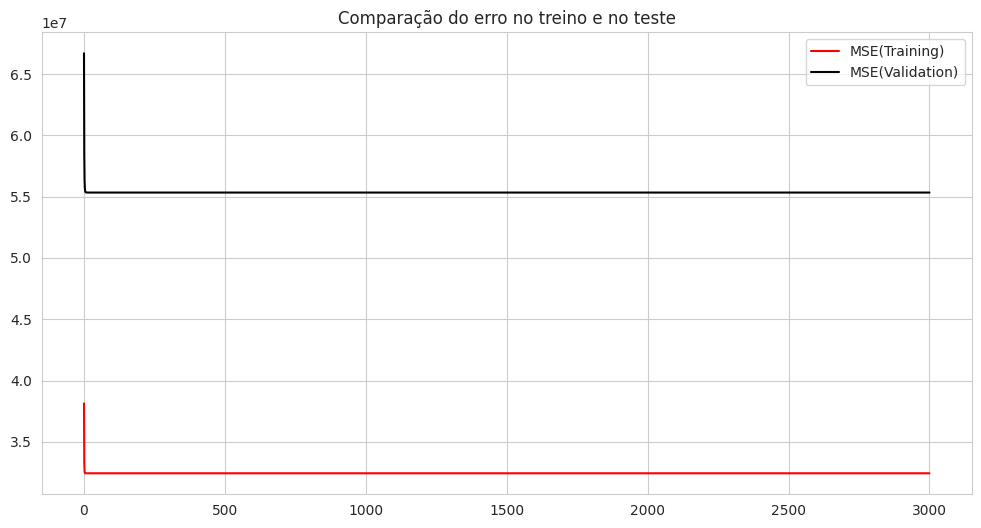

In [ ]:
out = model.predict(x.reshape(-1,1))
print(f"MAE: {np.mean(abs(y_test-y_pred))}")
print(f"MSE: {0.5*np.mean((y_test-y_pred)**2)} ")

plt.figure(figsize=(12,6))
plt.title('Comparação do erro no treino e no teste')
plt.plot(history['loss'],color='red',label='MSE(Training)')
plt.plot(history['val_loss'],color='black',label='MSE(Validation)')
plt.legend(loc='best')

7/7 [==============================] - 0s 2ms/step
Rede Keras: 

MSE: 79282579.709738 
MAE: 7123.270897979918

MLPRegressor Sklearn: 

MSE: 78260336.25267844 
MAE: 7066.9015964126775

Implementação da rede: 

MSE: 55331092.84602505 
MAE: 7968.519290913376


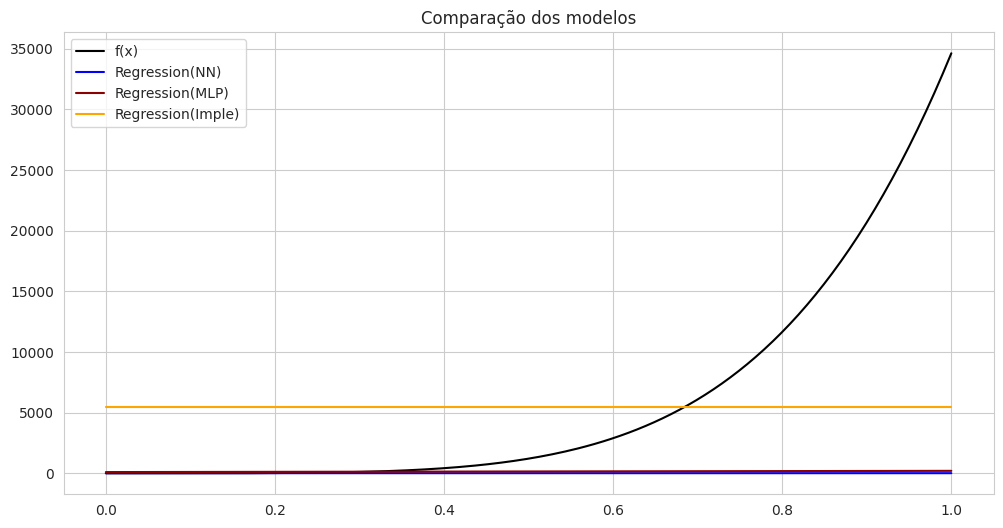

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Comparação dos modelos')
plt.plot(x,y[0],color='black',label='f(x)')
plt.plot(x, model_.predict(x),color='blue',label='Regression(NN)')
plt.plot(x, model__.predict(x.reshape(-1,1)),color='darkred',label='Regression(MLP)')
plt.plot(x.reshape(-1,1), out ,color = 'orange', label='Regression(Imple)')
plt.legend()

print('Rede Keras: \n')
print(f"MSE: {0.5*np.mean((y_test-y_pred_)**2)} ")
print(f"MAE: {np.mean(abs(y_test-y_pred_))}")
print('\nMLPRegressor Sklearn: \n')
print(f"MSE: {0.5*np.mean((y_test-y_pred__)**2)} ")
print(f"MAE: {np.mean(abs(y_test-y_pred__))}")
print('\nImplementação da rede: \n')
print(f"MSE: {0.5*np.mean((y_test-y_pred)**2)} ")
print(f"MAE: {np.mean(abs(y_test-y_pred))}")

## Questão 03

$\hspace{0.5cm}$Considere um problema de classificação de padrões constituído de oito padrões. A
distribuição dos padrões forma um círculo centrado na origem de raio unitário e contido no
círculo um losango também centrado na origem e com lados iguais à raiz de 2. Os dados das
classes C1, C2, C3, C4 correspondem aos quatro setores do losango e as outras quatro
classes correspondem aos setores delimitados pelo círculo e os lados do losango. Após gerar
aleatoriamente dados que venham formar estas distribuições de dados, selecione um conjunto
de treinamento e um conjunto de validação. Treine uma rede perceptron para classificar os
padrões associados a cada uma das classes. Verifique o desempenho do classificador usando
o conjunto de validação e calculando a matriz de confusão.

In [80]:
def create_df(n_examples):
    x = np.random.uniform(-1,1,n_examples)
    y = np.random.uniform(-1,1,n_examples)

    df = pd.DataFrame(data={'x':[0.4],'y':[0.4], 'Class':[0]})

    for i in range(len(x)):

        if y[i] <= 1 - x[i] and x[i] >= 0 and y[i] >= 0:
            df.loc[len(df)] = [x[i], y[i], 0]

        elif (y[i] >= 1 - x[i] and x[i] >= 0 and y[i] >= 0 and x[i]**2 + y[i]**2 <= 1):
            df.loc[len(df)] = [x[i],y[i], 4]

        elif y[i] <= 1 + x[i] and x[i] <= 0 and y[i] >= 0:
            df.loc[len(df)] = [x[i],y[i], 1]

        elif y[i] >= 1 + x[i] and x[i] <= 0 and y[i] >= 0 and x[i]**2 + y[i]**2 <= 1:
            df.loc[len(df)] = [x[i],y[i], 5]

        elif y[i] >= x[i] - 1 and x[i] >= 0 and y[i] <= 0:
            df.loc[len(df)] = [x[i],y[i], 3]

        elif y[i] <= x[i] - 1 and x[i] >= 0 and y[i] <= 0 and x[i]**2 + y[i]**2 <= 1:
            df.loc[len(df)] = [x[i],y[i], 7]

        elif y[i] >= -1 - x[i] and x[i] <= 0 and y[i] <= 0:
            df.loc[len(df)] = [x[i],y[i], 2]

        elif y[i] <= -1 - x[i] and x[i] <= 0 and y[i] <= 0 and x[i]**2 + y[i]**2 <= 1:
            df.loc[len(df)] = [x[i],y[i], 6]

    return df

In [81]:
df = create_df(5000)

In [82]:
df = df.sort_values(by='Class')
df

,x,y,Class
0,0.400000,0.400000,0.0
1657,0.114990,0.460480,0.0
1659,0.779108,0.157062,0.0
1668,0.144340,0.605530,0.0
1669,0.580898,0.362620,0.0
...,...,...,...
3257,0.252561,-0.786742,7.0
3258,0.565571,-0.664938,7.0
1967,0.880849,-0.458648,7.0
3362,0.955316,-0.082493,7.0


In [83]:
df['Class'].value_counts()

Class
0.0    650
2.0    635
3.0    619
1.0    611
6.0    368
5.0    358
7.0    352
4.0    336
Name: count, dtype: int64

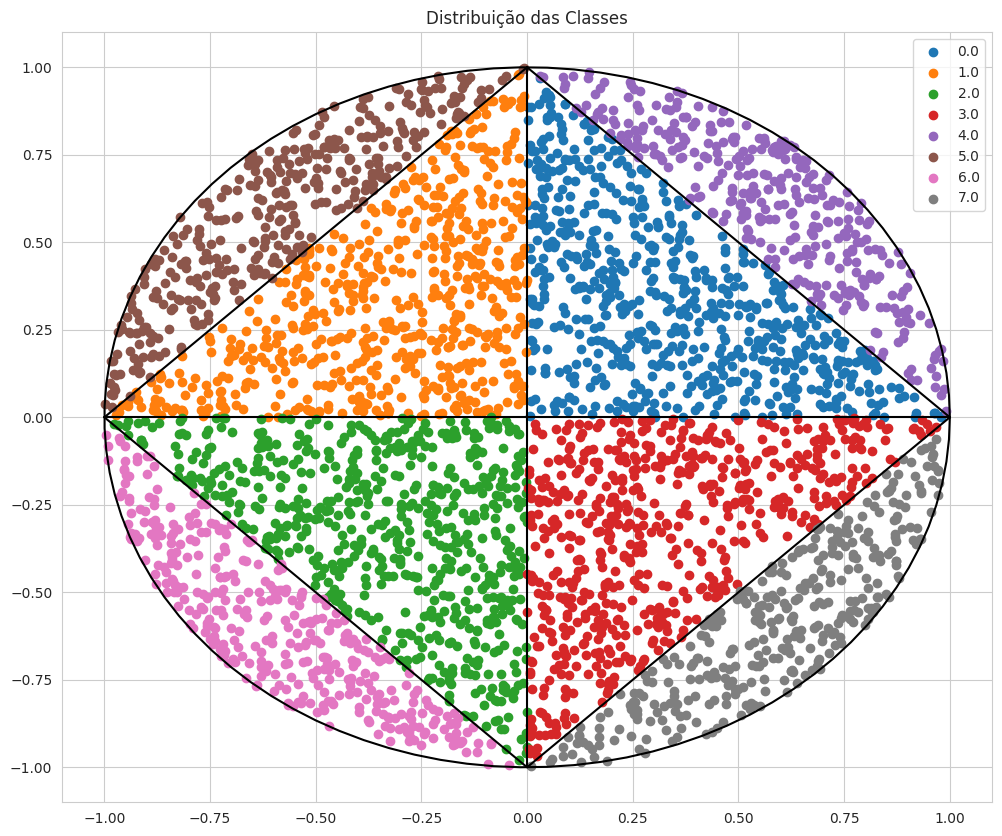

In [84]:
def plot2d(df):

    classes = df['Class'].unique()

    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)

    for classe in classes:
        valores = df[df['Class'] == classe].values
        x,y = valores[:,0] , valores[:,1]
        ax.scatter(x,y, label=classe)

    #círculo
    theta = np.linspace( 0 , 2 * np.pi , 100)

    raio = 1

    a = raio * np.cos( theta )
    b = raio * np.sin( theta )

    #reta 1
    x1 = np.linspace(0,1,100)
    f1 = lambda x: 1 - x
    y1 = f1(x1)

    #reta 2
    x2 = np.linspace(-1,0,100)
    f2 = lambda x: 1 + x
    y2 = f2(x2)

    #reta 3
    x3 = np.linspace(-1,0,100)
    f3 = lambda x: - 1 - x
    y3 = f3(x3)

    #reta 4
    x4 = np.linspace(0,1,100)
    f4 = lambda x: x - 1
    y4 = f4(x4)

    #eixo x e y
    x = np.linspace(-1,1,100)
    y = np.linspace(-1,1,100)

    ax.plot(a,b, x1,y1, x2,y2, x3,y3 , x4,y4, c='black')
    ax.plot(np.zeros((100,)),y, x,np.zeros((100,)) ,c='black')
    ax.set_title("Distribuição das Classes")
    ax.legend(loc="best")

plot2d(df)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(df[['x','y']].values,df['Class'].values,test_size=0.3)
y_train

array([2., 7., 3., ..., 0., 0., 3.])

In [86]:
classes = [f'C{i}' for i in range(1,9)]
classes

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']

### MLPClassifier Sklearn sem Momentum

In [87]:
model = MLPClassifier(max_iter=1000, solver='adam')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

Reporte: 
              precision    recall  f1-score   support

          C1       1.00      0.99      1.00       212
          C2       0.99      1.00      1.00       177
          C3       0.99      0.98      0.99       194
          C4       0.97      0.99      0.98       184
          C5       1.00      1.00      1.00       104
          C6       1.00      1.00      1.00        94
          C7       1.00      0.99      1.00       119
          C8       0.99      0.99      0.99        95

    accuracy                           0.99      1179
   macro avg       0.99      0.99      0.99      1179
weighted avg       0.99      0.99      0.99      1179

Matriz de Confusão: 



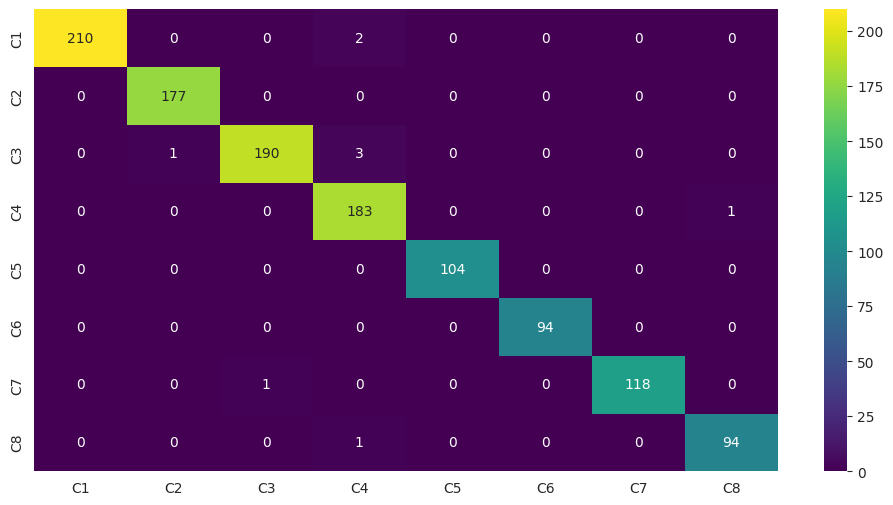

In [88]:
print('Reporte: ')
print(classification_report(y_test,y_pred, target_names=classes))
print('Matriz de Confusão: \n')
plt.figure(figsize=(12,6))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt="d", cmap='viridis', xticklabels=classes, yticklabels=classes)
plt.show()

### MLPClassifier Sklearn com Momentum

In [ ]:
model = MLPClassifier(max_iter=1000, solver='sgd', momentum=0.9)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Reporte: 
              precision    recall  f1-score   support

          C1       0.96      0.95      0.96       162
          C2       0.98      0.97      0.97       207
          C3       1.00      0.96      0.98       206
          C4       0.94      1.00      0.97       190
          C5       0.97      0.96      0.97       108
          C6       0.95      1.00      0.98       106
          C7       0.96      1.00      0.98        92
          C8       1.00      0.93      0.96       108

    accuracy                           0.97      1179
   macro avg       0.97      0.97      0.97      1179
weighted avg       0.97      0.97      0.97      1179

Matriz de Confusão: 



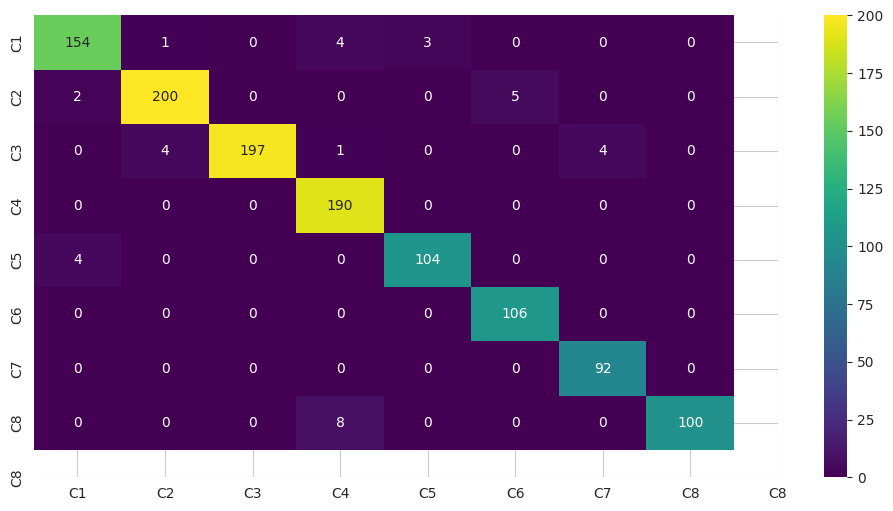

In [ ]:
print('Reporte: ')
print(classification_report(y_test,y_pred, target_names=classes))
print('Matriz de Confusão: \n')
plt.figure(figsize=(12,6))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt="d", cmap='viridis', xticklabels=classes, yticklabels=classes)
plt.show()

## Questão 04

$\hspace{0.5cm}$Utilize a rede neural perceptron de múltiplas camadas para fazer a predição de um passo,
até predição de três passos, da série temporal $x(n) = \sin^{2}
(n) + \cos(n+\cos(n))  $.Avalie o desempenho mostrando para cada caso os erros de predição.

In [112]:
x = np.arange(0,100)
f = lambda x: np.sin(x)**2 + np.cos(x + np.cos(x))
y = f(x)

In [113]:
df = pd.DataFrame(y, index=x, columns=['Saída'])

<Axes: >

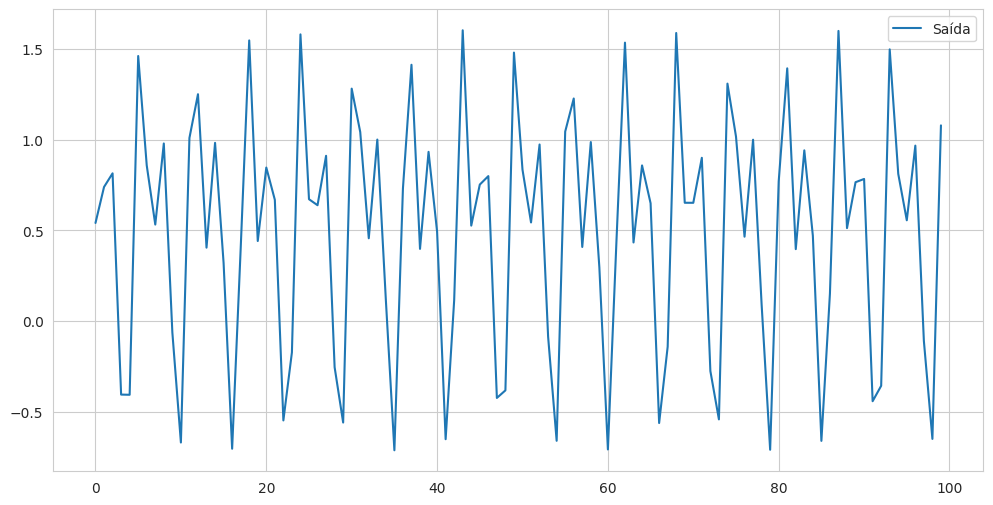

In [114]:
df.plot(figsize=(12,6))

In [115]:
def series_to_supervised(serie, steps_in):
    features = pd.DataFrame()
    features['t'] = serie
    for i in range(1, steps_in+1):
        features['t-'+str(i)] = serie.shift(i)
    features = features.iloc[steps_in:]
    return features

In [116]:
ts = df['Saída']
k = 12
data_features = series_to_supervised(ts, k)
data_features

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12
12,1.249658,1.008832,-0.669434,-0.062893,0.978311,0.531544,0.857538,1.460239,-0.406359,-0.405311,0.813765,0.738563,0.540302
13,0.404245,1.249658,1.008832,-0.669434,-0.062893,0.978311,0.531544,0.857538,1.460239,-0.406359,-0.405311,0.813765,0.738563
14,0.981733,0.404245,1.249658,1.008832,-0.669434,-0.062893,0.978311,0.531544,0.857538,1.460239,-0.406359,-0.405311,0.813765
15,0.319912,0.981733,0.404245,1.249658,1.008832,-0.669434,-0.062893,0.978311,0.531544,0.857538,1.460239,-0.406359,-0.405311
16,-0.703644,0.319912,0.981733,0.404245,1.249658,1.008832,-0.669434,-0.062893,0.978311,0.531544,0.857538,1.460239,-0.406359
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.555134,0.810846,1.496792,-0.356902,-0.441869,0.782695,0.764930,0.511969,1.598441,0.151278,-0.660392,0.469849,0.940395
96,0.966451,0.555134,0.810846,1.496792,-0.356902,-0.441869,0.782695,0.764930,0.511969,1.598441,0.151278,-0.660392,0.469849
97,-0.109378,0.966451,0.555134,0.810846,1.496792,-0.356902,-0.441869,0.782695,0.764930,0.511969,1.598441,0.151278,-0.660392
98,-0.649542,-0.109378,0.966451,0.555134,0.810846,1.496792,-0.356902,-0.441869,0.782695,0.764930,0.511969,1.598441,0.151278


In [117]:
X = data_features[['t-12','t-11','t-10','t-9','t-8','t-7','t-6','t-5','t-4','t-3']].values
y = data_features[['t-2','t-1','t']].values

X_train,y_train = X[:len(X)//2 + 20], y[:len(y)//2 + 20]
X_test,y_test = X[len(X)//2 + 20:], y[len(y)//2 + 20:]

### MLPRegressor Sklearn

In [118]:
model_ = MLPRegressor(hidden_layer_sizes=(100,),max_iter=1000)
history = model_.fit(X_train,y_train)
y_pred_ = model_.predict(X_test)

In [119]:
print(f"MAE: {np.mean(abs(y_test-y_pred_))}")
print(f"MSE: {0.5*np.mean((y_test-y_pred_)**2)} ")

MAE: 0.04421114280115125
MSE: 0.0015599004159737814 


### Entrada f(0) até f(9)

In [120]:
x_input = np.array([[f(i) for i in range(10)]])
x_input

array([[ 0.54030231,  0.73856271,  0.81376534, -0.40531079, -0.40635904,
         1.46023929,  0.85753803,  0.53154379,  0.97831141, -0.06289252]])

In [121]:
print('Saída do modelo MLPRegressor: \n')
print(model_.predict(x_input))
print('\nValores originais: \n')
print(f(10),f(11),f(12))

Saída do modelo MLPRegressor: 

[[-0.61309838  0.96666292  1.21443948]]

Valores originais: 

-0.6694342222603569 1.0088317080406155 1.2496583824586474


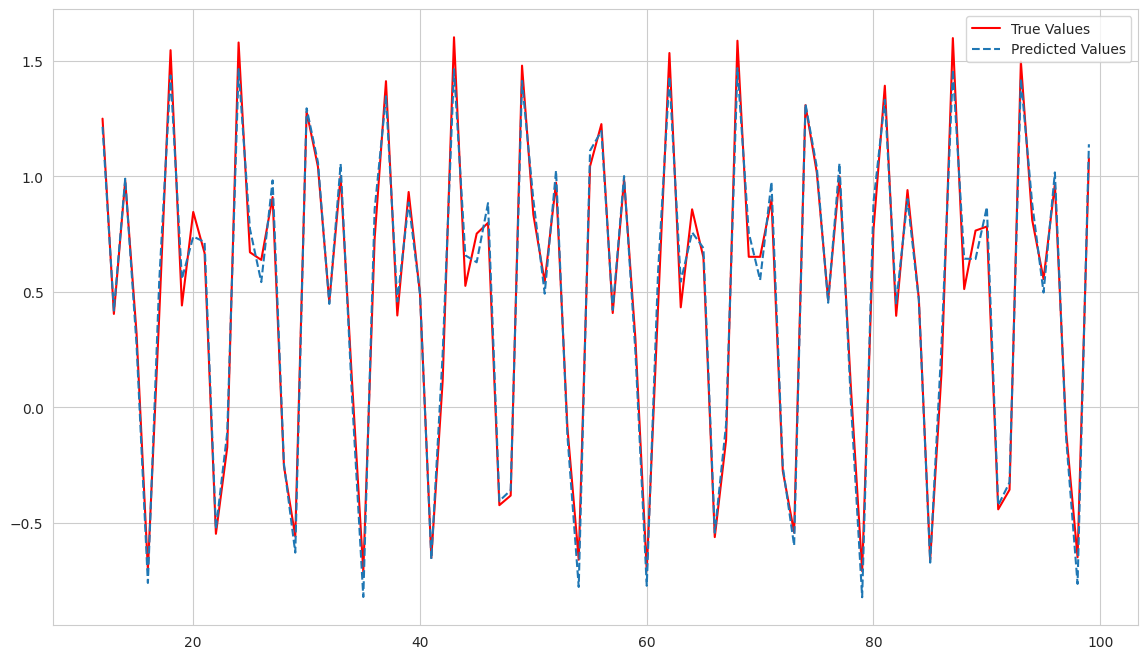

In [122]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.plot(x[k:],f(x[k:]),color='red', label='True Values')
ax.plot(x[k:], model_.predict(X)[:,2], '--',label='Predicted Values' )
ax.legend(loc='best')

Conjunto de teste

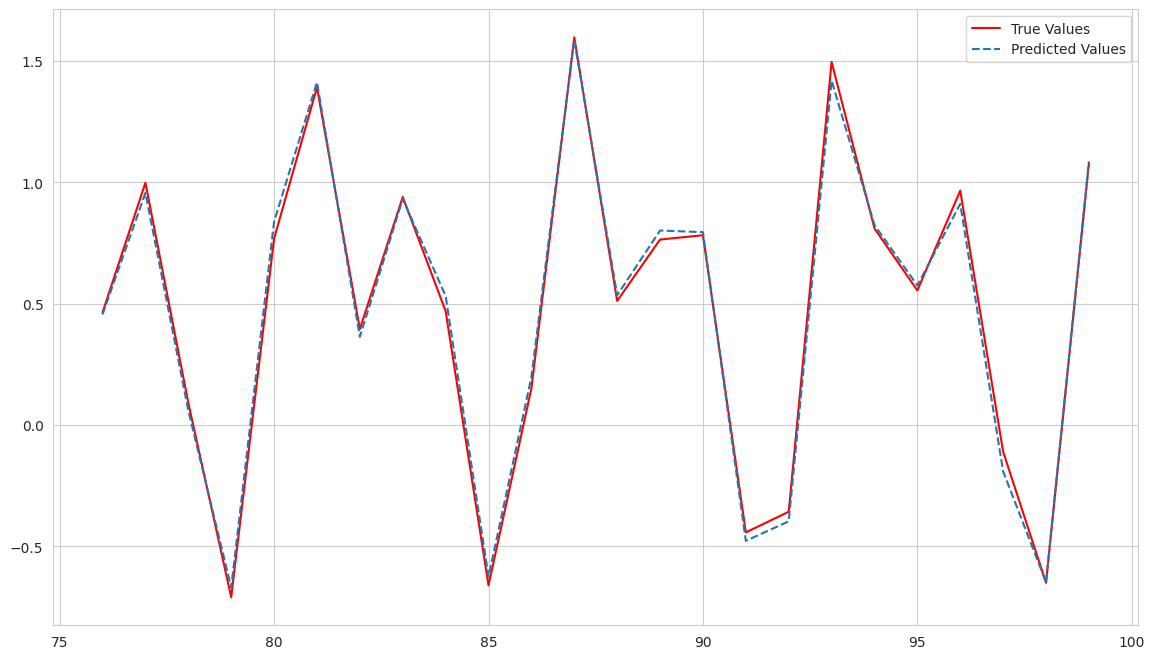

In [123]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.plot(x[-24:],y_test[:,2],color='red', label='True Values')
ax.plot(x[-24:], model.predict(X_test)[:,2], '--',label='Predicted Values' )
ax.legend(loc='best')

### Implementação da rede

In [100]:
dim_entrada = X_train.shape[1]
dim_saida = y_train.shape[1]

In [102]:
model = NeuralNetwork(func_cost=mse, learning_rate=1e-1)

model.layers.append(Layer(dim_entrada=dim_entrada, dim_saida=10, activation=sigmoid))
model.layers.append(Layer(dim_entrada=10, dim_saida=10, activation=sigmoid))
model.layers.append(Layer(dim_entrada=10, dim_saida=dim_saida, activation=linear))

model.fit(X_train,y_train, X_test, y_test, epochs=3000, verbose=300)
y_pred = model.predict(X_test)

epoch:    0/3000 loss_train: 0.55075431
epoch:  300/3000 loss_train: 0.00805218
epoch:  600/3000 loss_train: 0.00474677
epoch:  900/3000 loss_train: 0.00320355
epoch: 1200/3000 loss_train: 0.00227317
epoch: 1500/3000 loss_train: 0.00167707
epoch: 1800/3000 loss_train: 0.00128360
epoch: 2100/3000 loss_train: 0.00101723
epoch: 2400/3000 loss_train: 0.00083156
epoch: 2700/3000 loss_train: 0.00069785
epoch: 3000/3000 loss_train: 0.00059828


In [103]:
print('Saída do MLPRegressor: \n')
print(f"MAE: {np.mean(abs(y_test-y_pred_))}")
print(f"MSE: {0.5*np.mean((y_test-y_pred_)**2)} ")
print('\nSaída da implementação: \n')
print(f"MAE: {np.mean(abs(y_test-y_pred))}")
print(f"MSE: {0.5*np.mean((y_test-y_pred)**2)} ")

Saída do MLPRegressor: 

MAE: 0.04106215076966142
MSE: 0.0013539535399075156 

Saída da implementação: 

MAE: 0.028106392391619866
MSE: 0.0006221760339660926 


### Entrada f(0) até f(9)

In [104]:
print('Saída do modelo MLPRegressor: \n')
print(model_.predict(x_input))
print('\nSaída da implementação: \n')
print(model.predict(x_input))
print('\nValores originais: \n')
print(f(10),f(11),f(12))

Saída do modelo MLPRegressor: 

[[-0.69320424  0.97860129  1.27590197]]

Saída da implementação: 

[[-0.64492678  1.06288636  1.26138846]]

Valores originais: 

-0.6694342222603569 1.0088317080406155 1.2496583824586474


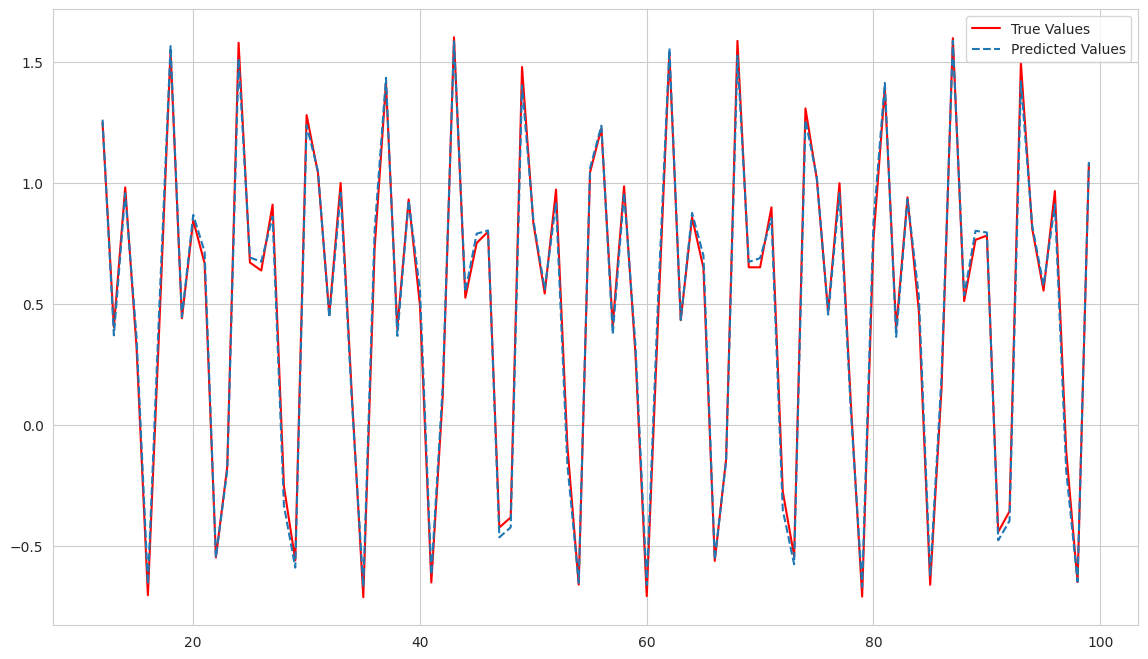

In [105]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.plot(x[k:],f(x[k:]),color='red', label='True Values')
ax.plot(x[k:], model.predict(X)[:,2], '--',label='Predicted Values' )
ax.legend(loc='best')

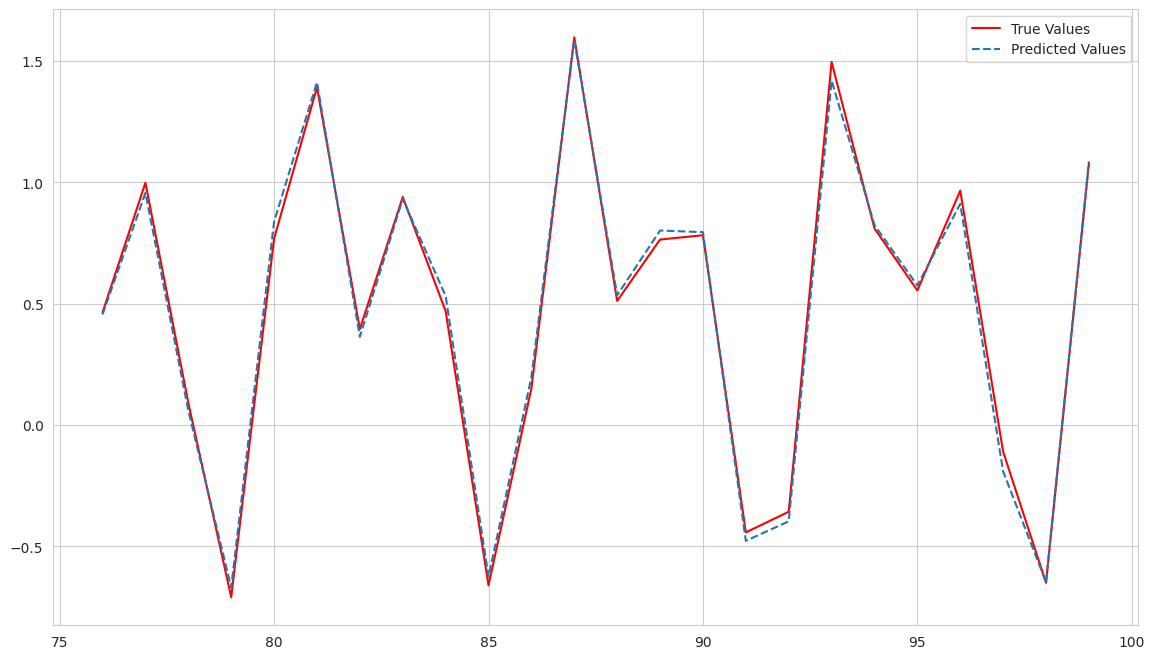

In [111]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.plot(x[-24:],y_test[:,2],color='red', label='True Values')
ax.plot(x[-24:], model.predict(X_test)[:,2], '--',label='Predicted Values' )
ax.legend(loc='best')